In [53]:
!pip install pandas numpy scikit-learn scipy matplotlib seaborn xgboost lightgbm catboost optuna


# Classification of Property Addresses- TF-IDF + XGBoost

Goal: develop an effective classifier, which revolves messy property address into one of:
['landparcel', 'commercial unit', 'flat', 'houseorplot', 'others'].

This notebook contains:
- EDA & basic cleaning
- Robust TF-IDF vectorization
- Optuna hyperparameter tuning 
- Cross-validation to have good estimates.
- Finally, full training on train_data.
- Assessment using the unmodified validation CSV.

Small Log: I experimented with some models (LightGBM / CatBoost / XGBoost). TF-IDF + XGBoost provided the most optimal combination of speed, interpretability, and accuracy on this dataset - and this notebook captures the decision made.

## Imports

In [54]:

import os
import re
import json
import time
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_fscore_support

warnings.filterwarnings('ignore')
np.random.seed(42)

TRAIN_CSV = r"D:\Property_Classification\task_dataset - training_dataset.csv"
VAL_CSV   = r"D:\Property_Classification\task_dataset - validation_dataset.csv"


os.makedirs("best_model", exist_ok=True)
os.makedirs("results", exist_ok=True)

print("Ready. Paths:")
print(" TRAIN:", TRAIN_CSV)
print(" VAL:  ", VAL_CSV)


Ready. Paths:
 TRAIN: D:\Property_Classification\task_dataset - training_dataset.csv
 VAL:   D:\Property_Classification\task_dataset - validation_dataset.csv


In [55]:

df_train = pd.read_csv(TRAIN_CSV)
df_val = pd.read_csv(VAL_CSV)

print("Train shape:", df_train.shape)
print("Val   shape:", df_val.shape)

display(df_train.head(4))
display(df_val.head(4))


Train shape: (8936, 2)
Val   shape: (2681, 2)


,property_address,categories
0,"New Ppid 1Kqttmg7, House, Property Id No.58C57...",houseorplot
1,"Property Of Rs No.12/2,Plot No. 01,House Numbe...",houseorplot
2,"Flat-504,Floor-5 Shanti Vista-Ii Wing C Bldg 9...",flat
3,"Flat-103,Floor-1 Eshamya Florenza Tower L S No...",flat


,property_address,categories
0,Shop No. Ii 108 And Ii 36 Radha Raman Textile ...,commercial unit
1,Vishwakarma Industrial Estate F-1Near Nh8 Pipo...,commercial unit
2,Shop No. 367 Karnal New Grain Market Near Mark...,commercial unit
3,"Patta No,57 Va 58,Khasra No 699,Village And Gp...",landparcel


## Exploring Dataset

In [56]:

print("\nTrain columns:", df_train.columns.tolist())
print("\nMissing values (train):\n", df_train.isna().sum())
print("\nLabel distribution (train):\n", df_train['categories'].value_counts())

print("\nSample messy addresses from train:")
for i, row in df_train.sample(6, random_state=42).iterrows():
    print(f"\n[{i}] label={row['categories']}")
    print(row['property_address'][:400])



Train columns: ['property_address', 'categories']

Missing values (train):
 property_address    0
categories          0
dtype: int64

Label distribution (train):
 categories
flat               3232
houseorplot        2673
others             1197
commercial unit     965
landparcel          869
Name: count, dtype: int64

Sample messy addresses from train:

[554] label=others
Property No J 708, Jiwan Niketan Lic Colony, Paschim Vihar, Block Jq Near Dda Market

[6304] label=houseorplot
Plot No.273 Pid No-053-W0177 Kr Puram Bangalore Sy.No.35 Sheegehalli Village Sheegehalli Village

[1330] label=flat
Dda Janta Flat No 28 B First Second Floor Phase Ii Katwaria Sarai Delhi

[6884] label=flat
All That Pieces And Parcels Of Old Block No. 600/A, Block No. 674, Admeasuring 2497 Sq. Mtrs. Known As ���Shree Residency��� Plot No. 12, Plot Area Admeasuring 52.70 Sq. Mtrs., Undivided Open Space Area Admeasuring 28.70 Sq. Mtrs. Total Plot Area Admeasuring 81.40 Sq. Mtrs., Undivided Common Road And Com

## Cleaning(preprocessing)

In [57]:

def clean_address(text):
    if text is None:
        return ""
    s = str(text)
    s = s.replace('\u00A0', ' ')
    s = s.replace('\n',' ').replace('\r',' ').replace('\t',' ')
    s = re.sub(r'([,./\-&]){2,}', r'\1', s)
    s = re.sub(r'[\x00-\x1f\x7f-\x9f]', ' ', s)
    s = ' '.join(s.split())
    return s.strip()

df_train['cleaned'] = df_train['property_address'].apply(clean_address)
df_val['cleaned'] = df_val['property_address'].apply(clean_address)

print("Examples after cleaning:")
for s in df_train['cleaned'].sample(5, random_state=1).tolist():
    print(" -", s[:180])


Examples after cleaning:
 - 301 Third Floor Na Near D.No 7-181/1 Sai Simhadri Residency 3 Vishakhapatnam Vishakhapatnam
 - Plot-18 Sanghvi Green Town S No 23/2-22,24/1-12,Mopadavillage, Denkada Mandal Vizianagaram 531162 Andhra Pradesh
 - Office No.C M.G. Road Sarswati Heritage, 3Rd Floor,Premises No.435, P.S. Jorasanko, Ward No.133, Under Kolkata Municipal Corporation Near Hotel White House
 - Flat-673,Floor-Ground Yashashree Residency S No.306/537+581,Plot No.16Vidyanagardhanori Pune 411032 Maharashtra
 - Flat-D/304,Floor-3 Shree Hari Complex Wingd Pl.No.115 To 118/S.No.169&170Sri Prasthanilemorenalasopara (W)Dist Thane Vasai-Virar City 401203 Maharashtra


## TF_IDF Vectorizer

In [71]:
tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1,2),
    strip_accents='unicode',
    lowercase=True,
    token_pattern=r'\b\w+\b'
)

X_train_tfidf = tfidf.fit_transform(df_train['cleaned'])
le = LabelEncoder()
y_train = le.fit_transform(df_train['categories'])

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("Classes:", list(le.classes_))


TF-IDF shape (train): (8936, 10000)
Classes: ['commercial unit', 'flat', 'houseorplot', 'landparcel', 'others']


In [72]:
params_quick = {
    "objective":"multi:softprob",
    "num_class": len(le.classes_),
    "eval_metric":"mlogloss",
    "tree_method":"hist",
    "eta":0.15,
    "max_depth":6,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "seed":42
}
dtrain_quick = xgb.DMatrix(X_train_tfidf, label=y_train)
bst_quick = xgb.train(params_quick, dtrain_quick, num_boost_round=120, verbose_eval=False)
print("Quick baseline trained.")


Quick baseline trained.


## Optuna Tuning

In [73]:

X_csc = X_train_tfidf.tocsc()
y = y_train

def optuna_objective(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": len(le.classes_),
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "grow_policy": "lossguide",              
        "max_leaves": trial.suggest_int("max_leaves", 16, 128),
        
        # Core parameters
        "eta": trial.suggest_float("eta", 0.03, 0.18),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        
        # Regularization 
        "lambda": trial.suggest_float("lambda", 0.5, 4.0),
        "alpha": trial.suggest_float("alpha", 0.0, 2.0),
        "gamma": trial.suggest_float("gamma", 0.0, 3.0),
        
        # Sampling
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

        "seed": 42,
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for tr_idx, vd_idx in skf.split(X_csc, y):
        dtrain = xgb.DMatrix(X_csc[tr_idx], label=y[tr_idx])
        dval   = xgb.DMatrix(X_csc[vd_idx], label=y[vd_idx])

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,                       
            evals=[(dval, "val")],
            early_stopping_rounds=60,                  
            verbose_eval=False
        )

        preds = np.argmax(model.predict(dval), axis=1)
        fold_score = f1_score(y[vd_idx], preds, average="macro")
        scores.append(fold_score)

    return np.mean(scores)



n_trials = 25  
study = optuna.create_study(direction="maximize")
study.optimize(optuna_objective, n_trials=n_trials, show_progress_bar=True)

print("\n======================")
print("Optuna Best Macro-F1:", study.best_value)
print("Best Params:")
print(study.best_params)

best_params = study.best_params.copy()
best_params.update({
    "objective": "multi:softprob",
    "num_class": len(le.classes_),
    "eval_metric": "mlogloss",
    "tree_method": "hist",
    "grow_policy": "lossguide",
    "seed": 42
})

[I 2025-11-20 22:03:31,503] A new study created in memory with name: no-name-4f5cdaad-9e4f-4ac2-8353-d4498cba368b


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-20 22:03:59,807] Trial 0 finished with value: 0.8374400885217188 and parameters: {'max_leaves': 80, 'eta': 0.14753311449196344, 'max_depth': 5, 'lambda': 3.5289906174991303, 'alpha': 1.8337708902573095, 'gamma': 2.9221291137818692, 'subsample': 0.8868077917131353, 'colsample_bytree': 0.667899805767787}. Best is trial 0 with value: 0.8374400885217188.
[I 2025-11-20 22:04:35,368] Trial 1 finished with value: 0.8678909172293156 and parameters: {'max_leaves': 60, 'eta': 0.1736255770907556, 'max_depth': 5, 'lambda': 2.910552232756965, 'alpha': 0.16142100832097928, 'gamma': 1.6122616826741587, 'subsample': 0.8831855102424662, 'colsample_bytree': 0.929556084258063}. Best is trial 1 with value: 0.8678909172293156.
[I 2025-11-20 22:05:18,522] Trial 2 finished with value: 0.8637150042593227 and parameters: {'max_leaves': 45, 'eta': 0.09619028560575146, 'max_depth': 7, 'lambda': 0.8074014208248737, 'alpha': 1.9023791654564217, 'gamma': 1.2293714621950578, 'subsample': 0.800079062928503

## K-Fold Test

In [74]:
params = best_params if 'best_params' in globals() else params_quick
X = X_train_tfidf
y = y_train

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_f1 = []
cv_acc = []

for fold, (tr_idx, vd_idx) in enumerate(skf.split(X, y), 1):
    dtr = xgb.DMatrix(X[tr_idx], label=y[tr_idx])
    dval = xgb.DMatrix(X[vd_idx], label=y[vd_idx])
    model = xgb.train(params, dtr, num_boost_round=600, evals=[(dval, "val")], early_stopping_rounds=60, verbose_eval=False)
    preds = np.argmax(model.predict(dval), axis=1)
    cv_f1.append(f1_score(y[vd_idx], preds, average='macro'))
    cv_acc.append(accuracy_score(y[vd_idx], preds))
    print(f"Fold {fold}: F1={cv_f1[-1]:.4f}, Acc={cv_acc[-1]:.4f}")

print(f"\nCV mean F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")
print(f"CV mean Acc: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")


Fold 1: F1=0.8879, Acc=0.9032
Fold 2: F1=0.8951, Acc=0.9121
Fold 3: F1=0.8996, Acc=0.9144
Fold 4: F1=0.8907, Acc=0.9049
Fold 5: F1=0.8985, Acc=0.9110

CV mean F1: 0.8944 ± 0.0045
CV mean Acc: 0.9091 ± 0.0043


In [75]:
X_alltrain = tfidf.transform(df_train['cleaned'])  
dall = xgb.DMatrix(X_alltrain, label=y_alltrain)

X_val_for_logs = tfidf.transform(df_val['cleaned'])
y_val_for_logs = le.transform(df_val['categories'])
dval_logs = xgb.DMatrix(X_val_for_logs, label=y_val_for_logs)

evals_result = {}
final_model = xgb.train(
    params,
    dall,
    num_boost_round=1000,
    evals=[(dall, 'train'), (dval_logs, 'val')],
    early_stopping_rounds=80,
    verbose_eval=50,
    evals_result=evals_result
)

print("Final model trained on training CSV only. Best iteration:", final_model.best_iteration)

with open("results/evals_result.json", "w") as f:
    json.dump(evals_result, f)


[0]	train-mlogloss:1.38462	val-mlogloss:1.38806
[50]	train-mlogloss:0.31794	val-mlogloss:0.39826
[100]	train-mlogloss:0.21867	val-mlogloss:0.33198
[150]	train-mlogloss:0.16820	val-mlogloss:0.30132
[200]	train-mlogloss:0.13707	val-mlogloss:0.28524
[250]	train-mlogloss:0.11405	val-mlogloss:0.27395
[300]	train-mlogloss:0.09706	val-mlogloss:0.26891
[350]	train-mlogloss:0.08439	val-mlogloss:0.26638
[400]	train-mlogloss:0.07478	val-mlogloss:0.26470
[450]	train-mlogloss:0.06669	val-mlogloss:0.26433
[486]	train-mlogloss:0.06192	val-mlogloss:0.26492
Final model trained on training CSV only. Best iteration: 406


## Fetching top 20 TF-IDF Words 


 Top 20 Most Important Words (Weight-Based Importance):

    Word  Importance
      no      1716.0
    road       702.0
 village       541.0
    plot       499.0
    unit       478.0
   floor       469.0
    near       451.0
       s       399.0
       1       375.0
       2       343.0
   nagar       338.0
 gujarat       270.0
       a       268.0
   india       253.0
    s no       252.0
  khasra       226.0
 plot no       223.0
   house       208.0
district       208.0
    shop       200.0


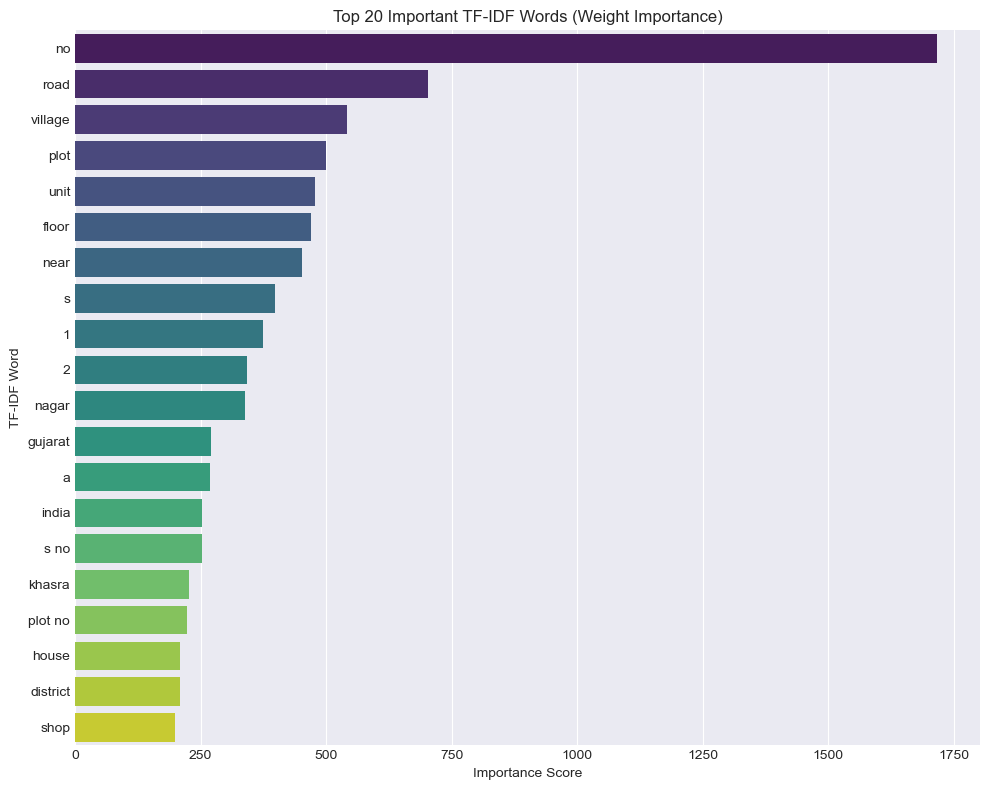


 Top 20 Most Important Words (Gain-Based Importance):

            Word      Gain
 behind infopark 78.417236
beside community 72.992981
            flat 69.670937
   opposite post 56.572121
        opposite 55.131317
     adjacent to 41.801361
            shop 41.232147
grama panchayath 35.470032
          beside 30.970778
          behind 29.162663
       office no 26.855589
         primary 25.339809
         flat no 22.913807
         shop no 22.274542
           floor 21.808453
         shed no 18.992935
            door 15.770429
       street no 15.583061
           house 14.737255
            roof 13.128960


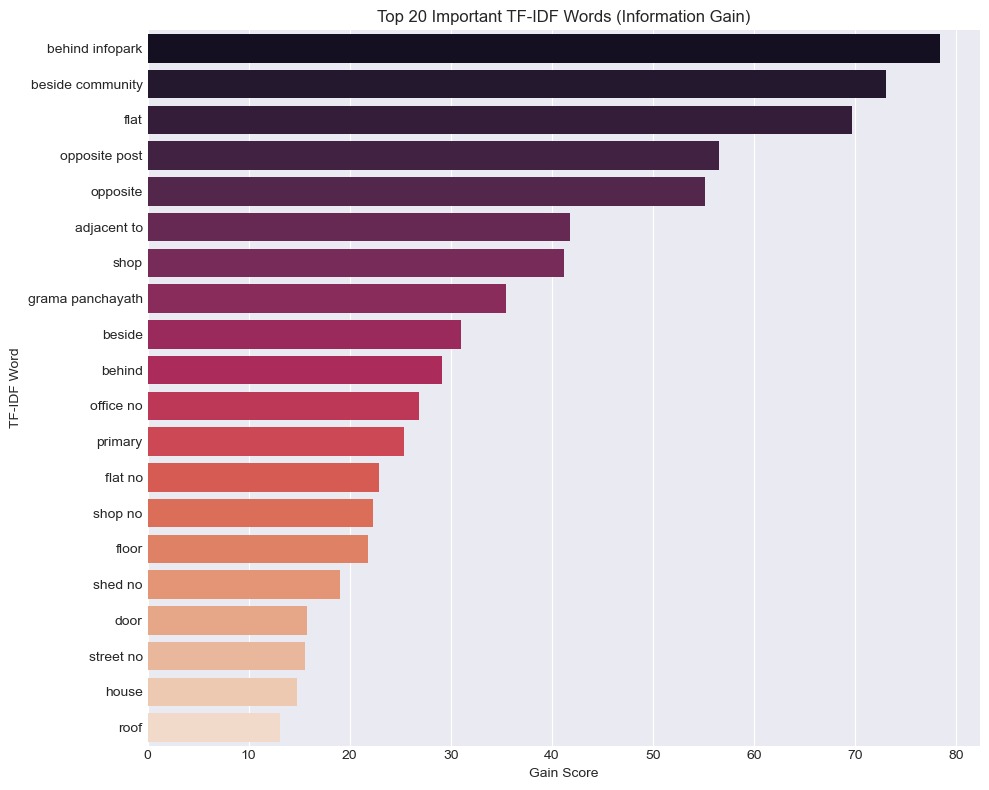

Total TF-IDF features: 10000
Features used by model: 941
Top word (weight): no
Top word (gain): behind infopark


In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


feature_names = tfidf.get_feature_names_out()   
raw_importance = final_model.get_score(importance_type='weight')


importance_mapped = []
for f, score in raw_importance.items():
    idx = int(f[1:])                
    if idx < len(feature_names):    
        importance_mapped.append((feature_names[idx], score))

importance_df = pd.DataFrame(importance_mapped, columns=['Word', 'Importance'])
importance_df = importance_df.sort_values("Importance", ascending=False).head(20)

print("\n Top 20 Most Important Words (Weight-Based Importance):\n")
print(importance_df.to_string(index=False))


plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Word', palette='viridis')
plt.title("Top 20 Important TF-IDF Words (Weight Importance)")
plt.xlabel("Importance Score")
plt.ylabel("TF-IDF Word")
plt.tight_layout()
plt.savefig("results/feature_importance_weight_mapped.png", dpi=150)
plt.show()



raw_gain = final_model.get_score(importance_type='gain')

gain_mapped = []
for f, score in raw_gain.items():
    idx = int(f[1:])
    if idx < len(feature_names):
        gain_mapped.append((feature_names[idx], score))

gain_df = pd.DataFrame(gain_mapped, columns=['Word', 'Gain'])
gain_df = gain_df.sort_values("Gain", ascending=False).head(20)

print("\n Top 20 Most Important Words (Gain-Based Importance):\n")
print(gain_df.to_string(index=False))


plt.figure(figsize=(10, 8))
sns.barplot(data=gain_df, x='Gain', y='Word', palette='rocket')
plt.title("Top 20 Important TF-IDF Words (Information Gain)")
plt.xlabel("Gain Score")
plt.ylabel("TF-IDF Word")
plt.tight_layout()
plt.savefig("results/feature_importance_gain_mapped.png", dpi=150)
plt.show()

print(f"Total TF-IDF features: {len(feature_names)}")
print(f"Features used by model: {len(raw_importance)}")
print(f"Top word (weight): {importance_df.iloc[0]['Word']}")
print(f"Top word (gain): {gain_df.iloc[0]['Word']}")


## Classification report

In [77]:
X_val_tfidf = tfidf.transform(df_val['cleaned'])
dval = xgb.DMatrix(X_val_tfidf)
val_preds = np.argmax(final_model.predict(dval), axis=1)
y_val_true = le.transform(df_val['categories'])

acc = accuracy_score(y_val_true, val_preds)
f1_macro = f1_score(y_val_true, val_preds, average='macro')
f1_weighted = f1_score(y_val_true, val_preds, average='weighted')

print("HOLD-OUT VALIDATION METRICS:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Macro F1 : {f1_macro:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}\n")

print("Classification report:\n")
print(classification_report(y_val_true, val_preds, target_names=le.classes_, zero_division=0))

print("Confusion matrix:\n")
print(confusion_matrix(y_val_true, val_preds))


HOLD-OUT VALIDATION METRICS:
  Accuracy : 0.9131
  Macro F1 : 0.8982
  Weighted F1: 0.9133

Classification report:

                 precision    recall  f1-score   support

commercial unit       0.99      0.92      0.95       290
           flat       0.95      0.95      0.95       970
    houseorplot       0.90      0.92      0.91       802
     landparcel       0.85      0.82      0.83       260
         others       0.83      0.86      0.84       359

       accuracy                           0.91      2681
      macro avg       0.90      0.89      0.90      2681
   weighted avg       0.91      0.91      0.91      2681

Confusion matrix:

[[267   9   6   0   8]
 [  1 921  24   3  21]
 [  0  18 738  23  23]
 [  0   0  35 212  13]
 [  3  21  14  11 310]]


## Learning Curves

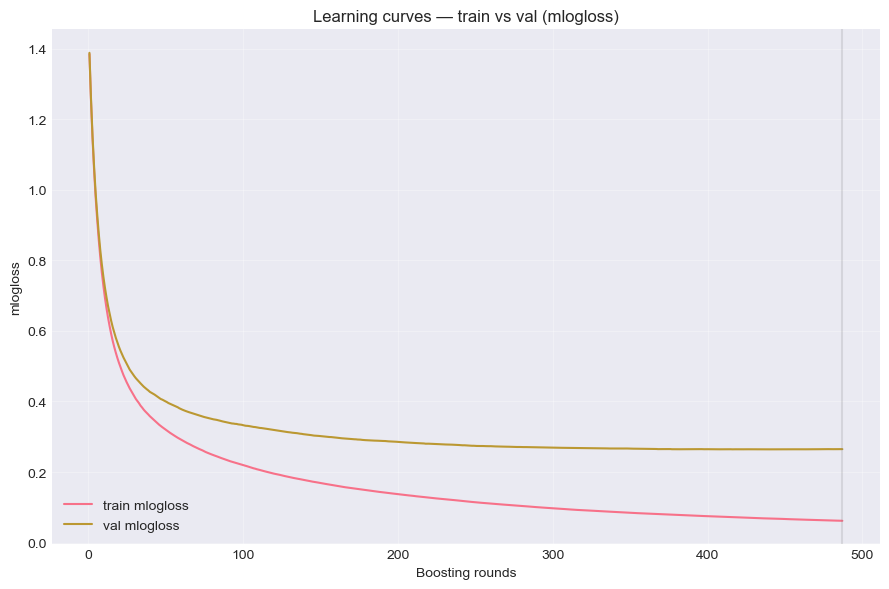

In [78]:
try:
    local_eval = evals_result
except NameError:
    with open("results/evals_result.json", "r") as f:
        local_eval = json.load(f)

train_loss = local_eval['train']['mlogloss']
val_loss = local_eval['val']['mlogloss']
iters = list(range(1, len(train_loss)+1))

plt.figure(figsize=(9,6))
plt.plot(iters, train_loss, label='train mlogloss')
plt.plot(iters, val_loss,   label='val mlogloss')
plt.axvline(x=len(train_loss), color='gray', alpha=0.2)
plt.xlabel('Boosting rounds')
plt.ylabel('mlogloss')
plt.title('Learning curves — train vs val (mlogloss)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("results/learning_curve_mlogloss.png", dpi=150)
plt.show()


## Confusion Matrix

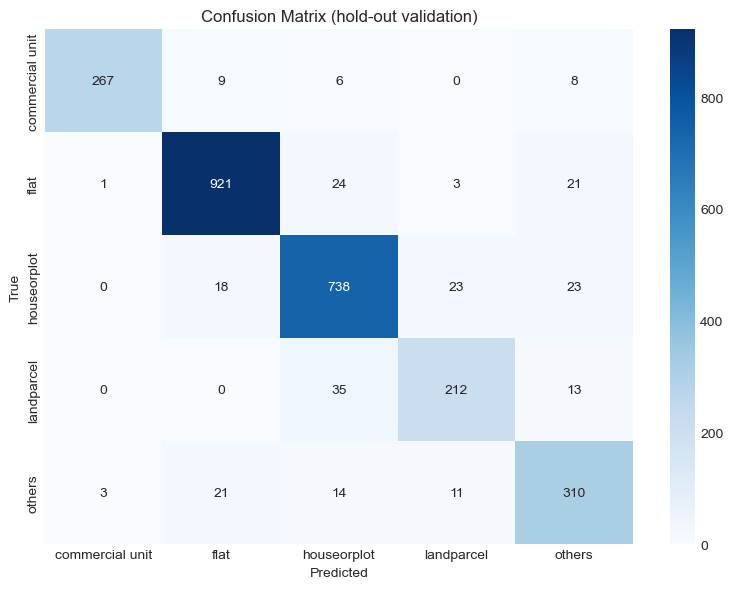

In [79]:
cm = confusion_matrix(y_val_true, val_preds)
labels = list(le.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (hold-out validation)')
plt.tight_layout()
plt.savefig("results/confusion_matrix.png", dpi=150)
plt.show()


## Class wise F1 Scores

          label  precision   recall       f1  support
commercial unit   0.985240 0.920690 0.951872      290
           flat   0.950464 0.949485 0.949974      970
    houseorplot   0.903305 0.920200 0.911674      802
         others   0.826667 0.863510 0.844687      359
     landparcel   0.851406 0.815385 0.833006      260


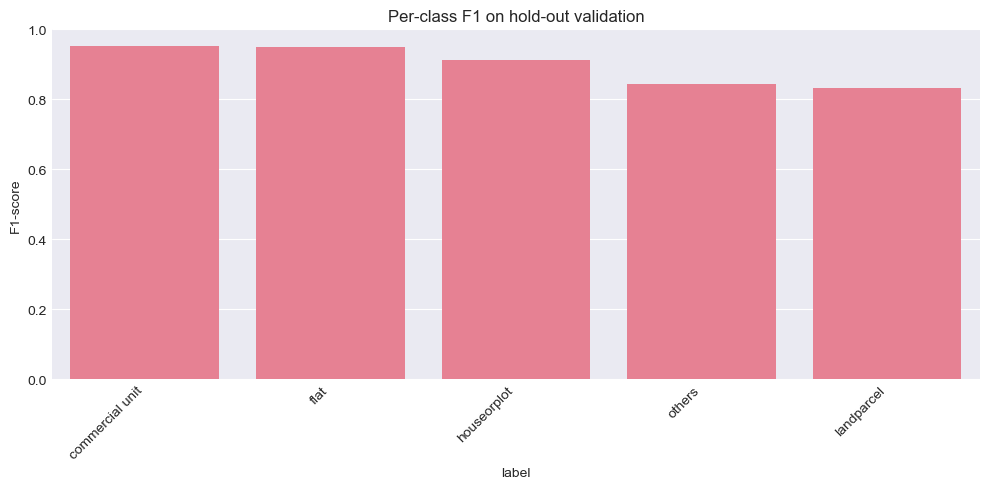

In [80]:

p, r, f, sup = precision_recall_fscore_support(y_val_true, val_preds, labels=range(len(le.classes_)), zero_division=0)
report_df = pd.DataFrame({
    'label': le.classes_,
    'precision': p,
    'recall': r,
    'f1': f,
    'support': sup
}).sort_values('f1', ascending=False)

print(report_df.to_string(index=False))

plt.figure(figsize=(10,5))
sns.barplot(x='label', y='f1', data=report_df, order=report_df['label'])
plt.ylim(0,1)
plt.ylabel('F1-score')
plt.title('Per-class F1 on hold-out validation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("results/per_class_f1.png", dpi=150)
plt.show()


## Saving the model

In [81]:

final_model.save_model("best_model/final_xgb_model.json")
joblib.dump(tfidf, "best_model/tfidf_vectorizer.pkl")
joblib.dump(le, "best_model/label_encoder.pkl")

with open("results/summary.txt", "w") as f:
    f.write(f"Validation accuracy: {acc:.4f}\n")
    f.write(f"Validation macro F1: {f1_macro:.4f}\n")
    f.write(f"Validation weighted F1: {f1_weighted:.4f}\n")
    f.write("Params:\n")
    f.write(json.dumps(params, indent=2))
print("Saved model and artifacts under best_model/ and results/")
print("Files in best_model:", os.listdir("best_model"))
print("Files in results:", os.listdir("results"))


Saved model and artifacts under best_model/ and results/
Files in best_model: ['final_xgb_model.json', 'label_encoder.pkl', 'tfidf_vectorizer.pkl']
Files in results: ['confusion_matrix.png', 'evals_result.json', 'feature_importance_gain_mapped.png', 'feature_importance_weight_mapped.png', 'learning_curve_mlogloss.png', 'per_class_f1.png', 'summary.txt']


## Sample Test

In [82]:

tfidf_loaded = joblib.load("best_model/tfidf_vectorizer.pkl")
label_enc_loaded = joblib.load("best_model/label_encoder.pkl")
model_loaded = xgb.Booster()
model_loaded.load_model("best_model/final_xgb_model.json")

def normalize_for_prediction(text):
    if text is None:
        return ""
    s = str(text)
    s = s.replace('\u00A0', ' ')
    s = s.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    s = re.sub(r'([,./\-&]){2,}', r'\1', s)
    s = re.sub(r'[\x00-\x1f\x7f-\x9f]', ' ', s)
    s = ' '.join(s.split())
    return s.strip()

def predict_address_production(address_text):
    cleaned = normalize_for_prediction(address_text)
    if not cleaned:
        return "unknown"
    vec = tfidf_loaded.transform([cleaned])
    dmat = xgb.DMatrix(vec)
    pred_idx = int(np.argmax(model_loaded.predict(dmat), axis=1)[0])
    return label_enc_loaded.inverse_transform([pred_idx])[0]

test_samples = [
    "Flat No 402, Skyline Residency, Mumbai",
    "Plot No 45, Sector 12, Navi Mumbai",
    "Shop No 7, Commercial Complex, Andheri",
    "Flat 101,\tGreen Park\nDelhi",
    "", None,
    "Plot/House No 26A, Block #5, Area-12"
]
for s in test_samples:
    print(f"'{s}' -> {predict_address_production(s)}")


'Flat No 402, Skyline Residency, Mumbai' -> flat
'Plot No 45, Sector 12, Navi Mumbai' -> houseorplot
'Shop No 7, Commercial Complex, Andheri' -> commercial unit
'Flat 101,	Green Park
Delhi' -> flat
'' -> unknown
'None' -> unknown
'Plot/House No 26A, Block #5, Area-12' -> houseorplot
